### Name: Riya Shyam Huddar
### Roll No.: MDS202431
### Quantum Computing - Portfolio Optimization Assignment 3

In [1]:
# Imports
import os
import pandas as pd
import numpy as np
import cvxpy as cp
from scipy import sparse
import clarabel
import matplotlib.pyplot as plt
import time

### Loading and Pre-processing

### Data Loading

Historical price data is loaded from individual CSV files, with each file
representing a single asset. The asset symbol is inferred from the filename.
Completely empty columns are removed, and all assets are combined into a
single DataFrame for downstream feature engineering and modeling.


In [3]:
data_dir = r"D:\CMI\IP\archive"

dfs = []

for file in os.listdir(data_dir):
    if file.endswith(".csv"):
        symbol = file.replace(".csv", "")
        file_path = os.path.join(data_dir, file)
        
        df = pd.read_csv(file_path)

        # Drop completely empty columns 
        df = df.dropna(axis=1, how="all")

        df["Symbol"] = symbol
        dfs.append(df)

raw_data = pd.concat(dfs, ignore_index=True)


In [4]:
raw_data.head()

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble,Company Name,Industry,ISIN Code
0,2007-11-27,ADANIPORTS,EQ,440.00,770.00,1050.00,770.0,959.0,962.90,984.72,27294366.0,2.687719e+15,NaN,9859619.0,0.3612,NaN,NaN,NaN
1,2007-11-28,ADANIPORTS,EQ,962.90,984.00,990.00,874.0,885.0,893.90,941.38,4581338.0,4.312765e+14,NaN,1453278.0,0.3172,NaN,NaN,NaN
2,2007-11-29,ADANIPORTS,EQ,893.90,909.00,914.75,841.0,887.0,884.20,888.09,5124121.0,4.550658e+14,NaN,1069678.0,0.2088,NaN,NaN,NaN
3,2007-11-30,ADANIPORTS,EQ,884.20,890.00,958.00,890.0,929.0,921.55,929.17,4609762.0,4.283257e+14,NaN,1260913.0,0.2735,NaN,NaN,NaN
4,2007-12-03,ADANIPORTS,EQ,921.55,939.75,995.00,922.0,980.0,969.30,965.65,2977470.0,2.875200e+14,NaN,816123.0,0.2741,NaN,NaN,NaN


### Data Cleaning and Asset Universe Selection

Dates are parsed and invalid entries removed before sorting the data by
asset and time. Closing prices are reshaped into a price matrix with
dates as rows and assets as columns.

Missing data is analyzed to understand coverage differences across assets.
Two universe constructions are considered: 
- a full universe requiring
complete data across all assets, and 
- an extended-history universe that
removes assets with excessive missing observations to retain a longer time
span.

In [7]:
raw_data["Date"] = pd.to_datetime(raw_data["Date"], errors="coerce")
raw_data = raw_data.dropna(subset=["Date"])
raw_data["Date"].isnull().sum()

0

In [9]:
raw_data = raw_data.sort_values(["Symbol", "Date"])

In [11]:
price_data = raw_data[["Date", "Symbol", "Close"]].copy()
price_data.head()

,Date,Symbol,Close
0,2007-11-27,ADANIPORTS,962.90
1,2007-11-28,ADANIPORTS,893.90
2,2007-11-29,ADANIPORTS,884.20
3,2007-11-30,ADANIPORTS,921.55
4,2007-12-03,ADANIPORTS,969.30


In [13]:
price_data = (
    price_data
    .groupby(["Date", "Symbol"], as_index=False)
    .last()
)

price_data.duplicated(subset=["Date", "Symbol"]).sum()

0

In [15]:
price_matrix = price_data.pivot(
    index="Date",
    columns="Symbol",
    values="Close"
)
price_matrix.head()

Symbol,ADANIPORTS,ASIANPAINT,AXISBANK,BAJAJ-AUTO,BAJAJFINSV,BAJFINANCE,BHARTIARTL,BPCL,BRITANNIA,CIPLA,...,TATAMOTORS,TATASTEEL,TCS,TECHM,TITAN,ULTRACEMCO,UPL,VEDL,WIPRO,ZEEL
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,NaN,381.65,26.70,NaN,NaN,50.75,NaN,399.25,756.90,1457.35,...,216.75,152.45,NaN,NaN,155.70,NaN,NaN,116.35,2724.20,1179.95
2000-01-04,NaN,385.55,26.85,NaN,NaN,48.10,NaN,370.50,754.55,1465.25,...,208.20,150.80,NaN,NaN,147.40,NaN,NaN,114.70,2942.15,1260.65
2000-01-05,NaN,383.00,26.30,NaN,NaN,44.60,NaN,359.95,735.30,1435.05,...,213.25,156.55,NaN,NaN,138.40,NaN,NaN,114.00,2990.10,1176.55
2000-01-06,NaN,377.50,25.95,NaN,NaN,45.25,NaN,380.30,785.65,1355.85,...,222.10,168.25,NaN,NaN,149.50,NaN,NaN,119.30,2932.25,1115.45
2000-01-07,NaN,385.70,24.80,NaN,NaN,42.90,NaN,379.85,848.50,1247.55,...,239.90,171.95,NaN,NaN,146.35,NaN,NaN,116.50,2697.70,1026.25


In [17]:
rows_before = len(price_matrix)
rows_after = len(price_matrix.dropna())

print(f"Original number of days: {rows_before}")
print(f"Days remaining if we drop all NaNs: {rows_after}")
print(f"Percentage of data lost: {100 * (1 - rows_after/rows_before):.2f}%")

Original number of days: 5306
Days remaining if we drop all NaNs: 2598
Percentage of data lost: 51.04%


In [19]:
# stocks with maximum NaN's 
price_matrix.isnull().sum().sort_values(ascending=False).head(10)

Symbol
COALINDIA     2708
NESTLEIND     2500
BAJAJFINSV    2105
BAJAJ-AUTO    2104
ADANIPORTS    1984
POWERGRID     1947
TECHM         1671
JSWSTEEL      1312
NTPC          1218
TCS           1167
dtype: int64

In [21]:
# APPROACH 1: Full Universe 
# We keep every single symbol, which forces the timeline to start 
# only when the "youngest" stock was listed.
price_matrix_full = price_matrix.dropna()

# APPROACH 2: Extended History
# We identify the stocks that are "killing" our history (missing > 1100 days).
# By removing just these few, we "unlock" many more years of data for the rest.
nan_counts = price_matrix.isnull().sum()
killers = nan_counts[nan_counts > 1100].index
price_matrix_extended = price_matrix.drop(columns=killers).dropna()

# --- DIAGNOSTICS ---
print("--- APPROACH 1: FULL UNIVERSE ---")
print(f"Stocks: {price_matrix_full.shape[1]}")
print(f"Days: {len(price_matrix_full)}")
print(f"Timeline: {price_matrix_full.index.min().date()} to {price_matrix_full.index.max().date()}")

print("\n--- APPROACH 2: EXTENDED HISTORY ---")
print(f"Stocks: {price_matrix_extended.shape[1]}")
print(f"Days: {len(price_matrix_extended)}")
print(f"Timeline: {price_matrix_extended.index.min().date()} to {price_matrix_extended.index.max().date()}")

--- APPROACH 1: FULL UNIVERSE ---
Stocks: 50
Days: 2598
Timeline: 2010-11-04 to 2021-04-30

--- APPROACH 2: EXTENDED HISTORY ---
Stocks: 38
Days: 4286
Timeline: 2004-01-23 to 2021-04-30


In [23]:
# --- STEP 1: Compute daily returns ---

returns_full = price_matrix_full.pct_change().dropna()
returns_extended = price_matrix_extended.pct_change().dropna()

print("Full universe returns shape:", returns_full.shape)
print("Extended universe returns shape:", returns_extended.shape)


Full universe returns shape: (2597, 50)
Extended universe returns shape: (4285, 38)


 ----
 -----

### 1. ML-Based Return or Risk Estimation

### Feature Engineering: Lagged and Rolling Return Features

To construct predictive inputs for the ML model, we generate lagged return
features (1, 2, and 5 days) and rolling statistics based on past information.
Rolling means capture short-term return trends, while rolling volatility
serves as a proxy for recent risk conditions.

All rolling features are shifted by one period to avoid look-ahead bias.
Features are constructed separately for the full and extended asset
universes.


In [25]:
# --- STEP 2: Lagged return features ---

# Full universe
lag1_full = returns_full.shift(1)
lag2_full = returns_full.shift(2)
lag5_full = returns_full.shift(5)

# Extended universe
lag1_ext = returns_extended.shift(1)
lag2_ext = returns_extended.shift(2)
lag5_ext = returns_extended.shift(5)

print("Lagged features created for both universes")


Lagged features created for both universes


In [31]:
# --- STEP 3: Rolling features ---

# Full universe
mean5_full = returns_full.shift(1).rolling(window=5).mean()
vol10_full = returns_full.shift(1).rolling(window=10).std()

# Extended universe
mean5_ext = returns_extended.shift(1).rolling(window=5).mean()
vol10_ext = returns_extended.shift(1).rolling(window=10).std()

print("Rolling features created for both universes")


Rolling features created for both universes


### Prediction Target Definition

The supervised learning target is defined as the next-period asset return,
denoted by $r_{t+1}$. Returns are shifted backward by one period so that
features constructed using information available at time $t$ are used to
predict returns at time $t+1$.

Formally, the learning problem is defined as
$$
\hat{r}_{t+1} = f(X_t),
$$
where $X_t$ denotes the vector of lagged and rolling features.

In [35]:
# --- STEP 4: Target (next-period return) ---

# Full universe
target_full = returns_full.shift(-1)

# Extended universe
target_ext = returns_extended.shift(-1)

print("Targets created for both universes")


Targets created for both universes


### ML Dataset Construction

Lagged and rolling features are combined into a feature matrix $X_t$ and
reshaped into long format, with each row corresponding to a
$(\text{Date}, \text{Symbol})$ pair. The target variable is the next-period
return $r_{t+1}$.

After merging features and targets, missing observations are removed once.
This procedure is applied separately to the full and extended universes to
create supervised learning datasets for model estimation.


In [39]:
# --- STEP 5A: Full universe ML dataset ---

X_full = pd.concat(
    [lag1_full, lag2_full, lag5_full, mean5_full, vol10_full],
    axis=1,
    keys=["lag1", "lag2", "lag5", "mean5", "vol10"]
)

# Stack to long format
X_full_long = X_full.stack(future_stack=True).reset_index()
y_full_long = target_full.stack(future_stack=True).reset_index()

# Rename columns
X_full_long.columns = ["Date", "Symbol", "lag1", "lag2", "lag5", "mean5", "vol10"]
y_full_long.columns = ["Date", "Symbol", "target"]

# Merge features and target
ml_full = pd.merge(X_full_long, y_full_long, on=["Date", "Symbol"])

# Drop NaNs once
ml_full = ml_full.dropna()

print("Full universe ML data shape:", ml_full.shape)


Full universe ML data shape: (129300, 8)


In [41]:
# --- STEP 5B: Extended universe ML dataset ---

X_ext = pd.concat(
    [lag1_ext, lag2_ext, lag5_ext, mean5_ext, vol10_ext],
    axis=1,
    keys=["lag1", "lag2", "lag5", "mean5", "vol10"]
)

# Stack to long format
X_ext_long = X_ext.stack(future_stack=True).reset_index()
y_ext_long = target_ext.stack(future_stack=True).reset_index()

# Rename columns
X_ext_long.columns = ["Date", "Symbol", "lag1", "lag2", "lag5", "mean5", "vol10"]
y_ext_long.columns = ["Date", "Symbol", "target"]

# Merge features and target
ml_ext = pd.merge(X_ext_long, y_ext_long, on=["Date", "Symbol"])

# Drop NaNs once
ml_ext = ml_ext.dropna()

print("Extended universe ML data shape:", ml_ext.shape)


Extended universe ML data shape: (162412, 8)


### Train-Test Split

The dataset is split into training and testing samples using a fixed
time-based cutoff. Observations prior to the split date are used for model
training, while later observations are reserved for out-of-sample evaluation.

This chronological split preserves the time ordering of the data and avoids
look-ahead bias. The procedure is applied separately to the full and extended
asset universes.


In [42]:
# --- STEP 6A: Train–test split (Full universe) ---

split_date = "2019-01-01"

train_full = ml_full[ml_full["Date"] < split_date]
test_full  = ml_full[ml_full["Date"] >= split_date]

X_train_full = train_full.drop(columns=["Date", "Symbol", "target"])
y_train_full = train_full["target"]

X_test_full = test_full.drop(columns=["Date", "Symbol", "target"])
y_test_full = test_full["target"]

print("Full universe:")
print("Train shape:", X_train_full.shape)
print("Test shape :", X_test_full.shape)


Full universe:
Train shape: (100500, 5)
Test shape : (28800, 5)


In [43]:
# --- STEP 6B: Train–test split (Extended universe) ---

train_ext = ml_ext[ml_ext["Date"] < split_date]
test_ext  = ml_ext[ml_ext["Date"] >= split_date]

X_train_ext = train_ext.drop(columns=["Date", "Symbol", "target"])
y_train_ext = train_ext["target"]

X_test_ext = test_ext.drop(columns=["Date", "Symbol", "target"])
y_test_ext = test_ext["target"]

print("\nExtended universe:")
print("Train shape:", X_train_ext.shape)
print("Test shape :", X_test_ext.shape)



Extended universe:
Train shape: (140524, 5)
Test shape : (21888, 5)


### Linear Regression Model Estimation

A linear regression model is trained to predict next-period returns
$r_{t+1}$ using lagged returns and rolling features. The model is estimated
separately for the full and extended universes.

Estimated coefficients are small in magnitude and exhibit limited stability
across universes, reflecting the weak predictability of daily returns.
This is consistent with earlier autocorrelation analysis and highlights the
noisy nature of return-based signals.


In [51]:
from sklearn.linear_model import LinearRegression

# --- Train Linear Regression (Full universe) ---
lr_full = LinearRegression()
lr_full.fit(X_train_full, y_train_full)

print("Linear Regression trained for Full universe")

# --- Train Linear Regression (Extended universe) ---
lr_ext = LinearRegression()
lr_ext.fit(X_train_ext, y_train_ext)

print("Linear Regression trained for Extended universe")

Linear Regression trained for Full universe
Linear Regression trained for Extended universe


In [131]:
print(pd.Series(lr_full.coef_, index=X_train_full.columns))

lag1     0.001106
lag2    -0.006106
lag5     0.002314
mean5   -0.066196
vol10   -0.012225
dtype: float64


In [133]:
print(pd.Series(lr_ext.coef_, index=X_train_ext.columns))

lag1    -0.002824
lag2     0.001889
lag5     0.003275
mean5   -0.082140
vol10   -0.018354
dtype: float64


### Out-of-Sample Prediction Performance

Model performance is evaluated using mean squared error (MSE) on the test set.
The resulting MSE values are small in absolute magnitude due to the low
variance of daily asset returns.

However, low MSE does not imply strong predictive power in this context.
Given that returns are close to zero on average, a naive baseline predicting
zero returns would achieve comparable error, indicating limited incremental
value from the linear model.


In [55]:
from sklearn.metrics import mean_squared_error

# Predict next-period returns
y_pred_full = lr_full.predict(X_test_full)

# Compute MSE
mse_full = mean_squared_error(y_test_full, y_pred_full)

print("Full universe MSE:", mse_full)


Full universe MSE: 0.0007070636884384123


In [57]:
# Predict next-period returns
y_pred_ext = lr_ext.predict(X_test_ext)

# Compute MSE
mse_ext = mean_squared_error(y_test_ext, y_pred_ext)

print("Extended universe MSE:", mse_ext)


Extended universe MSE: 0.0007766879473943744


### ML-Predicted Expected Returns

Out-of-sample return predictions $\hat{r}_{t+1}$ from the ML model are attached
to the test dataset and reshaped into a Date × Symbol matrix. This matrix is
interpreted as a time-varying expected return input $\mu_t$ for portfolio
construction.

The procedure is applied separately to the full and extended universes to
enable consistent downstream portfolio optimization and comparison.


In [59]:
# --- STEP 9A: Expected returns (Full universe) ---

# Attach predictions to test data
pred_full_df = test_full[["Date", "Symbol"]].copy()
pred_full_df["expected_return"] = y_pred_full

# Pivot to Date × Symbol matrix
mu_full = pred_full_df.pivot(
    index="Date",
    columns="Symbol",
    values="expected_return"
)

print("Full universe expected return matrix shape:", mu_full.shape)
mu_full.head()


Full universe expected return matrix shape: (576, 50)


Symbol,ADANIPORTS,ASIANPAINT,AXISBANK,BAJAJ-AUTO,BAJAJFINSV,BAJFINANCE,BHARTIARTL,BPCL,BRITANNIA,CIPLA,...,TATAMOTORS,TATASTEEL,TCS,TECHM,TITAN,ULTRACEMCO,UPL,VEDL,WIPRO,ZEEL
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-01,-0.000560,0.000596,0.000412,0.000914,0.000093,0.000135,0.000252,0.000914,0.000516,0.000495,...,0.000598,0.000432,0.000625,0.000003,-0.000281,0.000434,-0.000042,0.000221,0.000110,-0.000762
2019-01-02,-0.000454,0.000310,0.000311,0.000520,0.000060,0.000064,0.000185,0.000431,0.000500,0.000517,...,0.000379,0.000398,0.000626,0.000045,-0.000287,0.000300,0.000162,0.000056,0.000461,-0.000916
2019-01-03,0.000262,0.000313,0.000381,0.000703,0.000491,0.000272,0.000566,0.000661,0.000455,0.000535,...,0.000587,0.000980,0.000294,0.000273,-0.000152,0.000467,0.000393,0.000624,0.000604,-0.000057
2019-01-04,0.000762,0.000311,0.000824,0.000765,0.000729,0.000698,0.000705,0.001048,0.000320,0.000842,...,0.000859,0.001404,0.000492,0.000881,-0.000118,0.000791,0.000506,0.001266,0.000632,0.000633
2019-01-07,0.000668,0.000340,0.000753,0.000433,0.000706,0.000934,0.000158,0.000703,0.000469,0.000842,...,0.000598,0.001318,0.000713,0.001313,0.000405,0.000985,0.000601,0.001069,0.000761,0.000822


In [61]:
# --- STEP 9B: Expected returns (Extended universe) ---

pred_ext_df = test_ext[["Date", "Symbol"]].copy()
pred_ext_df["expected_return"] = y_pred_ext

mu_ext = pred_ext_df.pivot(
    index="Date",
    columns="Symbol",
    values="expected_return"
)

print("Extended universe expected return matrix shape:", mu_ext.shape)
mu_ext.head()


Extended universe expected return matrix shape: (576, 38)


Symbol,ASIANPAINT,AXISBANK,BAJFINANCE,BHARTIARTL,BPCL,BRITANNIA,CIPLA,DRREDDY,EICHERMOT,GAIL,...,SBIN,SHREECEM,SUNPHARMA,TATAMOTORS,TATASTEEL,TITAN,UPL,VEDL,WIPRO,ZEEL
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-01,0.000853,0.000852,0.000527,0.000549,0.001240,0.000895,0.000935,0.000896,0.001188,0.000155,...,0.000660,0.000665,0.000546,0.001022,0.000790,0.000163,0.000236,0.000576,0.000396,-0.000634
2019-01-02,0.000628,0.000454,0.000306,0.000211,0.000703,0.000897,0.000787,0.000923,0.000919,0.000264,...,0.000477,0.000676,0.000291,0.000756,0.000901,-0.000067,0.000410,0.000405,0.000841,-0.000976
2019-01-03,0.000535,0.000825,0.000657,0.001178,0.001229,0.000717,0.001018,0.001038,0.002183,0.001063,...,0.000896,0.000870,-0.000308,0.001079,0.001488,-0.000053,0.000598,0.001142,0.000839,0.000272
2019-01-04,0.000651,0.001207,0.000979,0.000841,0.001316,0.000633,0.001130,0.001079,0.002578,0.001041,...,0.000964,0.000891,-0.000018,0.001062,0.001637,0.000102,0.000912,0.001457,0.000956,0.000845
2019-01-07,0.000672,0.000867,0.001289,0.000273,0.000842,0.000882,0.001220,0.001033,0.002727,0.000959,...,0.000645,0.001351,0.000507,0.000669,0.001535,0.000695,0.000756,0.001143,0.001161,0.000991


----

### 2. Portfolio Construction Using ML Outputs

### Covariance Estimation and Portfolio Optimization Inputs

The asset return covariance matrix is estimated using in-sample (training
period) returns only. This sample covariance is treated as a fixed risk input
for out-of-sample portfolio construction.

ML-predicted expected returns $\mu_t$ are annualized and combined with the
annualized covariance matrix in a variance-constrained Markowitz optimization
problem. Portfolio weights are computed at the first test-date rebalance and
used for downstream performance evaluation.


In [63]:
# --- STEP 11A: Covariance (Full universe) ---

# Training-period returns only
train_returns_full = returns_full.loc[returns_full.index < split_date]

# Sample covariance matrix
cov_full = train_returns_full.cov()

print("Full universe covariance shape:", cov_full.shape)


Full universe covariance shape: (50, 50)


In [65]:
# --- STEP 11B: Covariance (Extended universe) ---

train_returns_ext = returns_extended.loc[returns_extended.index < split_date]

cov_ext = train_returns_ext.cov()

print("Extended universe covariance shape:", cov_ext.shape)


Extended universe covariance shape: (38, 38)


In [67]:
mu_full_annual = mu_full * 252
mu_ext_annual  = mu_ext * 252

In [69]:
# --- STEP 11B: Covariance (Extended universe) ---

train_returns_ext = returns_extended.loc[returns_extended.index < split_date]

cov_ext = train_returns_ext.cov()

print("Extended universe covariance shape:", cov_ext.shape)


Extended universe covariance shape: (38, 38)


In [71]:
# Annualize covariance matrices
cov_full_annual = cov_full * 252
cov_ext_annual  = cov_ext * 252


In [73]:
def solve_markowitz_variance_constrained(mu, cov, risk_target):
    n = len(mu)
    w = cp.Variable(n)

    objective = cp.Maximize(mu.values @ w)
    constraints = [
        cp.quad_form(w, cov.values) <= risk_target**2,
        cp.sum(w) == 1,
        w >= 0
    ]

    prob = cp.Problem(objective, constraints)
    prob.solve(solver=cp.CLARABEL)

    return w.value, prob.value


In [75]:
rebalance_date = mu_full_annual.index[0]   # first test date
rebalance_date


Timestamp('2019-01-01 00:00:00')

### ML-Based Portfolio Construction

ML-predicted expected returns $\mu_t$ are used as inputs to a
variance-constrained Markowitz optimizer. Portfolios are constructed at the
start of the test period for multiple risk targets and held fixed
out-of-sample.

Portfolio returns are computed by applying the optimized weights to realized
test-period returns. The procedure is performed separately for the full and
extended universes to assess robustness across asset sets and risk levels.


In [77]:
risk_targets = [0.12, 0.15, 0.20]
weights_full = {}

for rt in risk_targets:
    mu_t = mu_full_annual.loc[rebalance_date].dropna()
    cov_t = cov_full_annual.loc[mu_t.index, mu_t.index]

    w, _ = solve_markowitz_variance_constrained(mu_t, cov_t, rt)
    weights_full[rt] = pd.Series(w, index=mu_t.index)

    print(f"Full | risk={rt} | sum weights={weights_full[rt].sum():.4f}")


Full | risk=0.12 | sum weights=1.0000
Full | risk=0.15 | sum weights=1.0000
Full | risk=0.2 | sum weights=1.0000


In [79]:
weights_ext = {}
ext_risk_targets = [0.17, 0.2, 0.25]
for rt in ext_risk_targets:
    mu_t = mu_ext_annual.loc[rebalance_date].dropna()
    cov_t = cov_ext_annual.loc[mu_t.index, mu_t.index]

    w, _ = solve_markowitz_variance_constrained(mu_t, cov_t, rt)
    weights_ext[rt] = pd.Series(w, index=mu_t.index)

    print(f"Extended | risk={rt} | sum weights={weights_ext[rt].sum():.4f}")


Extended | risk=0.17 | sum weights=1.0000
Extended | risk=0.2 | sum weights=1.0000
Extended | risk=0.25 | sum weights=1.0000


In [81]:
test_returns_full = returns_full.loc[returns_full.index >= split_date]
test_returns_ext  = returns_extended.loc[returns_extended.index >= split_date]


In [83]:
portfolio_returns_full = {}

for rt, w in weights_full.items():
    assets = w.index.intersection(test_returns_full.columns)
    portfolio_returns_full[rt] = test_returns_full[assets] @ w[assets]


In [85]:
portfolio_returns_ext = {}

for rt, w in weights_ext.items():
    assets = w.index.intersection(test_returns_ext.columns)
    portfolio_returns_ext[rt] = test_returns_ext[assets] @ w[assets]


In [157]:
from IPython.display import display

def show_weight_tables_by_risk(
    weights_dict,
    threshold=1e-5,
    decimals=6
):
    for rt, w in weights_dict.items():
        print(f"\n=== Risk target: {rt} ===")

        w_clean = w.copy()
        w_clean[w_clean.abs() <= threshold] = 0.0
        w_clean = w_clean[w_clean != 0.0]

        table = (
            w_clean
            .rename("weight")
            .reset_index()
            .rename(columns={"index": "Symbol"})
            .sort_values("weight", ascending=False)
            .reset_index(drop=True)
        )

        with pd.option_context(
            "display.float_format", f"{{:.{decimals}f}}".format
        ):
            display(table)


In [161]:
show_weight_tables_by_risk(weights_full, threshold=1e-4)


=== Risk target: 0.12 ===


,Symbol,weight
0,COALINDIA,0.119380
1,NESTLEIND,0.105260
2,HEROMOTOCO,0.096016
3,HINDUNILVR,0.087377
4,POWERGRID,0.085516
5,DRREDDY,0.077557
6,TCS,0.063569
7,CIPLA,0.056317
8,BAJAJ-AUTO,0.054021
9,BRITANNIA,0.046067



=== Risk target: 0.15 ===


,Symbol,weight
0,COALINDIA,0.268754
1,HEROMOTOCO,0.243204
2,BAJAJ-AUTO,0.108719
3,TCS,0.094026
4,HINDUNILVR,0.065786
5,EICHERMOT,0.050155
6,DRREDDY,0.048771
7,BRITANNIA,0.045243
8,CIPLA,0.037466
9,BPCL,0.033156



=== Risk target: 0.2 ===


,Symbol,weight
0,HEROMOTOCO,0.466088
1,COALINDIA,0.453415
2,BAJAJ-AUTO,0.059816
3,BPCL,0.020681


### Portfolio Performance Evaluation

Out-of-sample portfolio performance is evaluated using cumulative returns,
annualized return, annualized volatility, and the Sharpe ratio. Performance
statistics are computed from daily portfolio returns and annualized using
standard scaling factors.

Portfolios are constructed at the beginning of the test period and held
fixed, so results reflect static allocation performance rather than dynamic
rebalancing.

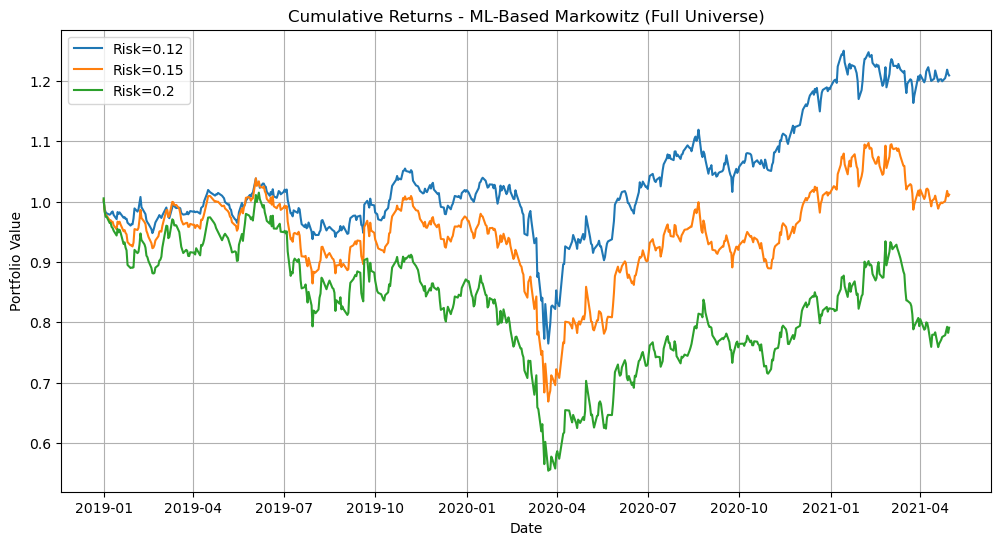

FULL UNIVERSE PERFORMANCE


,Risk Target,Annualized Return,Annualized Volatility,Sharpe Ratio
0,0.120000,10.16%,19.36%,0.525
1,0.150000,3.16%,23.08%,0.137
2,0.200000,-6.13%,28.70%,-0.214


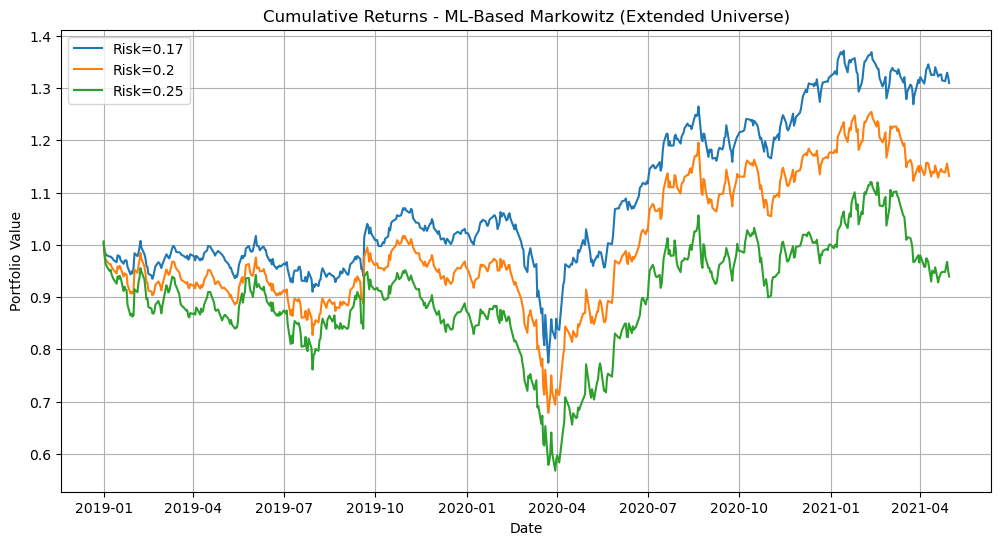

EXTENDED UNIVERSE PERFORMANCE


,Risk Target,Annualized Return,Annualized Volatility,Sharpe Ratio
0,0.170000,14.18%,21.91%,0.647
1,0.200000,8.90%,26.48%,0.336
2,0.250000,2.58%,32.62%,0.079


In [240]:
def evaluate_portfolios(portfolio_returns_dict, title_prefix):
    summary = []

    plt.figure(figsize=(12, 6))

    for rt, rets in portfolio_returns_dict.items():
        rets = rets.dropna()

        ann_return = rets.mean() * 252
        ann_vol = rets.std() * np.sqrt(252)
        sharpe = ann_return / ann_vol if ann_vol > 0 else np.nan

        summary.append({
            "Risk Target": rt,
            "Annualized Return": ann_return,
            "Annualized Volatility": ann_vol,
            "Sharpe Ratio": sharpe
        })

        cum_returns = (1 + rets).cumprod()
        plt.plot(cum_returns, label=f"Risk={rt}")

    plt.title(f"Cumulative Returns - {title_prefix}")
    plt.xlabel("Date")
    plt.ylabel("Portfolio Value")
    plt.legend()
    plt.grid(True)
    plt.show()

    return pd.DataFrame(summary)


# --- FULL UNIVERSE ---
summary_full = evaluate_portfolios(
    portfolio_returns_full,
    "ML-Based Markowitz (Full Universe)"
)

print("FULL UNIVERSE PERFORMANCE")
display(summary_full.style.format({
    "Annualized Return": "{:.2%}",
    "Annualized Volatility": "{:.2%}",
    "Sharpe Ratio": "{:.3f}"
}))


# --- EXTENDED UNIVERSE ---
summary_ext = evaluate_portfolios(
    portfolio_returns_ext,
    "ML-Based Markowitz (Extended Universe)"
)

print("EXTENDED UNIVERSE PERFORMANCE")
display(summary_ext.style.format({
    "Annualized Return": "{:.2%}",
    "Annualized Volatility": "{:.2%}",
    "Sharpe Ratio": "{:.3f}"
}))


### Comparison with standard Markowitz portfolio and simple baseline (equal-weight)

In [101]:
# --- CLASSIC MARKOWITZ (FULL & EXTENDED) ---

def classic_markowitz_weights(returns_train, cov_annual, risk_targets):
    weights = {}
    
    # Historical mean returns (daily → annualized)
    mu_classic = returns_train.mean() * 252
    
    for rt in risk_targets:
        mu_t = mu_classic.dropna()
        cov_t = cov_annual.loc[mu_t.index, mu_t.index]
        
        w, _ = solve_markowitz_variance_constrained(mu_t, cov_t, rt)
        weights[rt] = pd.Series(w, index=mu_t.index)
    
    return weights


# --- FULL UNIVERSE ---
classic_weights_full = classic_markowitz_weights(
    train_returns_full,
    cov_full_annual,
    risk_targets
)

# Realized returns
classic_returns_full = {}
for rt, w in classic_weights_full.items():
    assets = w.index.intersection(test_returns_full.columns)
    classic_returns_full[rt] = test_returns_full[assets] @ w[assets]


# --- EXTENDED UNIVERSE ---
classic_weights_ext = classic_markowitz_weights(
    train_returns_ext,
    cov_ext_annual,
    ext_risk_targets
)

classic_returns_ext = {}
for rt, w in classic_weights_ext.items():
    assets = w.index.intersection(test_returns_ext.columns)
    classic_returns_ext[rt] = test_returns_ext[assets] @ w[assets]

print("Classic Markowitz portfolios constructed (Full & Extended)")


Classic Markowitz portfolios constructed (Full & Extended)


In [176]:
# --- BASELINE 2: Equal-Weight (Full & Extended) ---

# Full universe
n_full = test_returns_full.shape[1]
w_eq_full = pd.Series(1 / n_full, index=test_returns_full.columns)
eq_returns_full = test_returns_full @ w_eq_full

# Extended universe
n_ext = test_returns_ext.shape[1]
w_eq_ext = pd.Series(1 / n_ext, index=test_returns_ext.columns)
eq_returns_ext = test_returns_ext @ w_eq_ext

### Comparison of ML Markowitz with CLassical and Equal weight

Across both asset universes, ML-based Markowitz portfolios underperform simpler
benchmarks. In the full universe, the ML portfolio achieves a Sharpe ratio of
0.53 at a 12% risk target, compared to 0.67 for classic Markowitz and 0.62 for
the equal-weight portfolio. As the risk target increases, ML performance
deteriorates sharply, with Sharpe ratios falling to −0.21 at a 20% risk target.

A similar pattern is observed in the extended universe. While the ML portfolio
reaches a Sharpe ratio of 0.65 at a 17% risk target, classic Markowitz achieves
a higher Sharpe of 0.74, and ML performance declines to 0.08 as the risk target
rises to 25%. In both universes, realized volatility consistently exceeds the
imposed risk targets, indicating sensitivity to estimation error.

Overall, these results show that ML-predicted expected returns add noise rather
than robust signal, and that simpler allocation rules such as equal-weighting
provide more stable risk-adjusted performance in this setting.


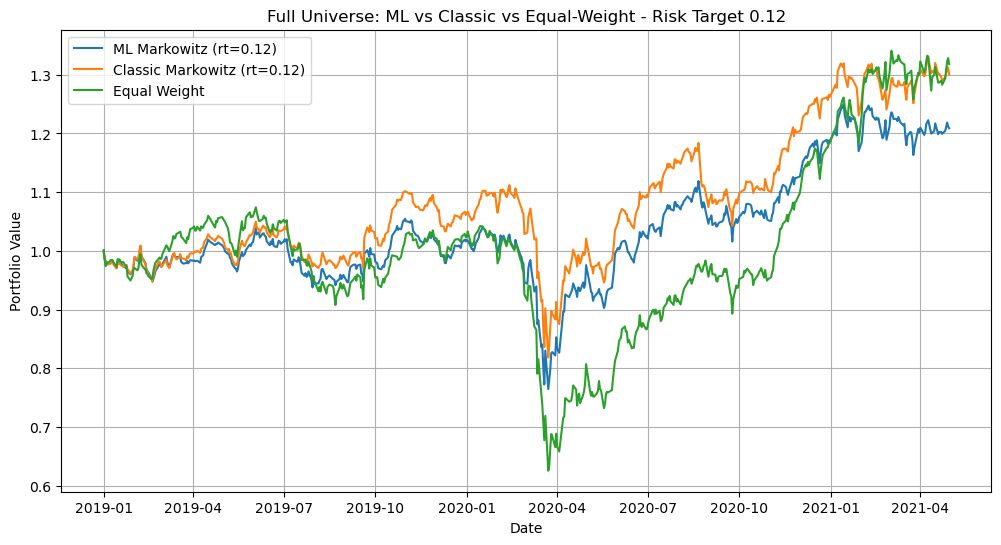

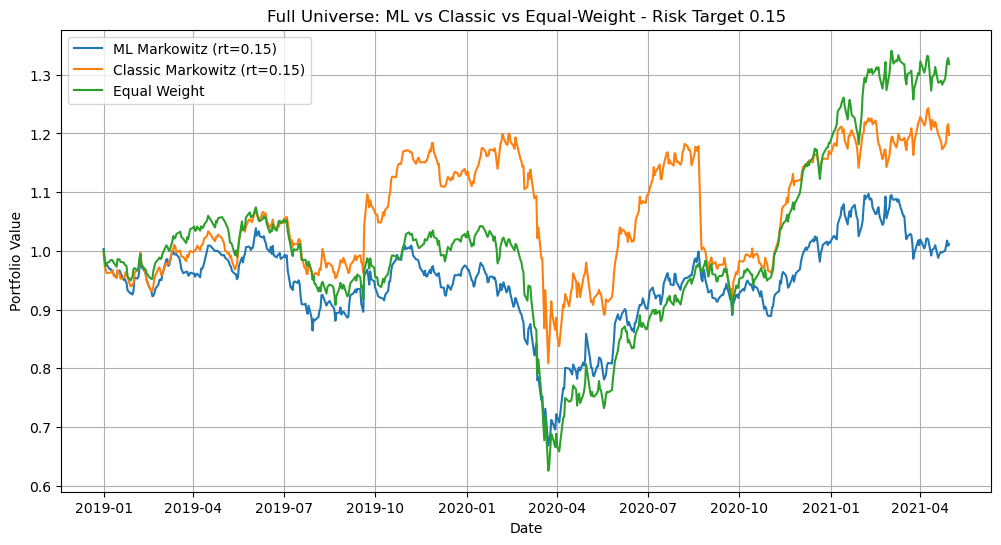

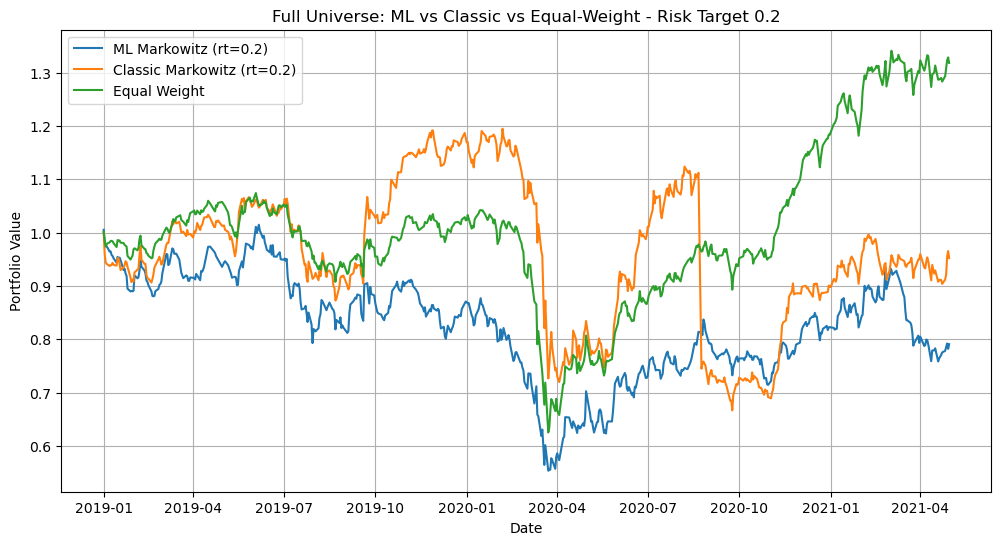

,Risk Target,Portfolio,Annualized Return,Annualized Volatility,Sharpe Ratio
0,0.120000,ML Markowitz (rt=0.12),10.16%,19.36%,0.525
1,0.120000,Classic Markowitz (rt=0.12),13.49%,20.02%,0.674
2,0.120000,Equal Weight,15.06%,24.33%,0.619
3,0.150000,ML Markowitz (rt=0.15),3.16%,23.08%,0.137
4,0.150000,Classic Markowitz (rt=0.15),11.41%,26.35%,0.433
5,0.150000,Equal Weight,15.06%,24.33%,0.619
6,0.200000,ML Markowitz (rt=0.2),-6.13%,28.70%,-0.214
7,0.200000,Classic Markowitz (rt=0.2),5.75%,37.73%,0.152
8,0.200000,Equal Weight,15.06%,24.33%,0.619


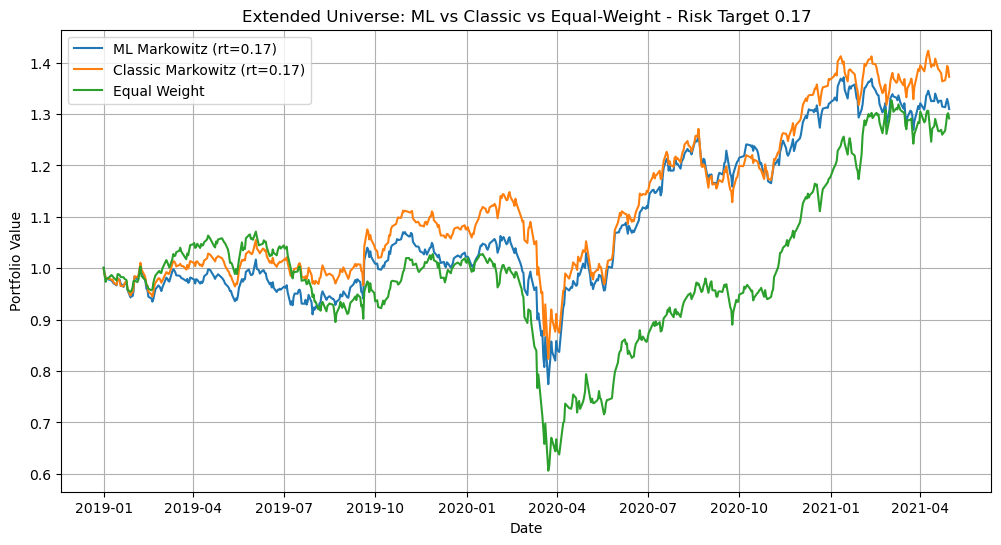

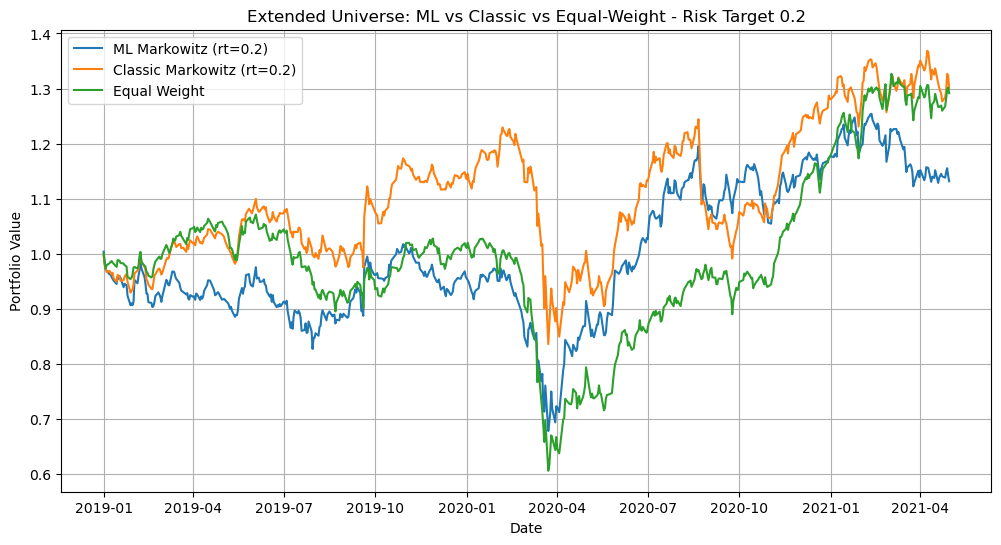

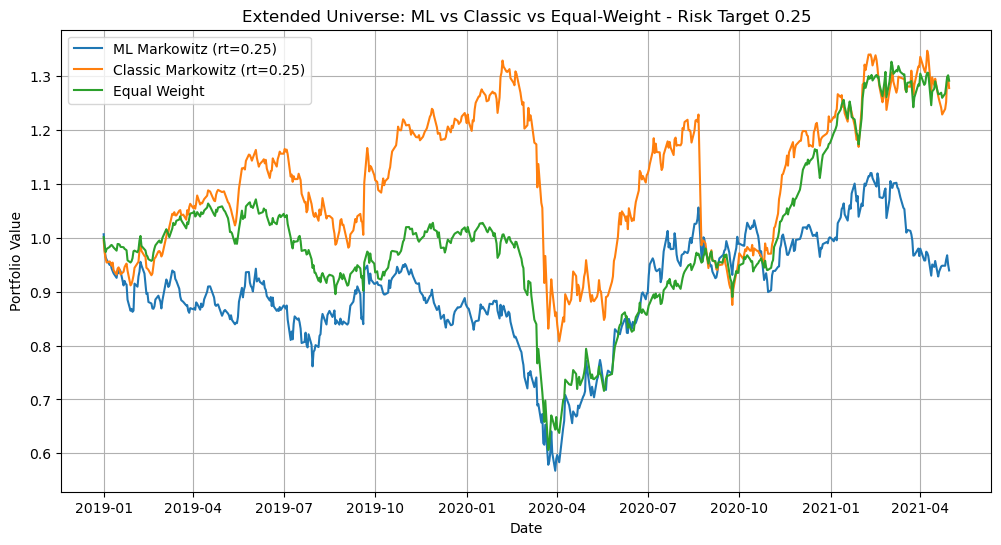

,Risk Target,Portfolio,Annualized Return,Annualized Volatility,Sharpe Ratio
0,0.170000,ML Markowitz (rt=0.17),14.18%,21.91%,0.647
1,0.170000,Classic Markowitz (rt=0.17),16.24%,21.94%,0.740
2,0.170000,Equal Weight,14.39%,25.22%,0.571
3,0.200000,ML Markowitz (rt=0.2),8.90%,26.48%,0.336
4,0.200000,Classic Markowitz (rt=0.2),14.99%,26.20%,0.572
5,0.200000,Equal Weight,14.39%,25.22%,0.571
6,0.250000,ML Markowitz (rt=0.25),2.58%,32.62%,0.079
7,0.250000,Classic Markowitz (rt=0.25),15.92%,31.74%,0.501
8,0.250000,Equal Weight,14.39%,25.22%,0.571


In [174]:
# --- MULTI-RISK COMPARISON FUNCTION ---

def compare_all_risk_levels(
    ml_returns_dict,
    classic_returns_dict,
    eq_returns,
    risk_targets,
    title_prefix
):
    all_summaries = []

    for rt in risk_targets:
        portfolios = {
            f"ML Markowitz (rt={rt})": ml_returns_dict[rt],
            f"Classic Markowitz (rt={rt})": classic_returns_dict[rt],
            "Equal Weight": eq_returns
        }

        summary = []
        plt.figure(figsize=(12, 6))

        for name, rets in portfolios.items():
            rets = rets.dropna()

            ann_ret = rets.mean() * 252
            ann_vol = rets.std() * np.sqrt(252)
            sharpe = ann_ret / ann_vol if ann_vol > 0 else np.nan

            summary.append({
                "Risk Target": rt,
                "Portfolio": name,
                "Annualized Return": ann_ret,
                "Annualized Volatility": ann_vol,
                "Sharpe Ratio": sharpe
            })

            plt.plot((1 + rets).cumprod(), label=name)

        plt.title(f"{title_prefix} - Risk Target {rt}")
        plt.xlabel("Date")
        plt.ylabel("Portfolio Value")
        plt.legend()
        plt.grid(True)
        plt.show()

        all_summaries.extend(summary)

    return pd.DataFrame(all_summaries)


# =========================
# FULL UNIVERSE
# =========================

summary_full_all = compare_all_risk_levels(
    ml_returns_dict=portfolio_returns_full,
    classic_returns_dict=classic_returns_full,
    eq_returns=eq_returns_full,
    risk_targets=risk_targets,
    title_prefix="Full Universe: ML vs Classic vs Equal-Weight"
)

display(summary_full_all.style.format({
    "Annualized Return": "{:.2%}",
    "Annualized Volatility": "{:.2%}",
    "Sharpe Ratio": "{:.3f}"
}))


# =========================
# EXTENDED UNIVERSE
# =========================

summary_ext_all = compare_all_risk_levels(
    ml_returns_dict=portfolio_returns_ext,
    classic_returns_dict=classic_returns_ext,
    eq_returns=eq_returns_ext,
    risk_targets=ext_risk_targets,
    title_prefix="Extended Universe: ML vs Classic vs Equal-Weight"
)

display(summary_ext_all.style.format({
    "Annualized Return": "{:.2%}",
    "Annualized Volatility": "{:.2%}",
    "Sharpe Ratio": "{:.3f}"
}))


### Portfolio Holdings and Concentration Analysis (Full Universe)

To better understand the performance differences across portfolio construction methods, we examine the **portfolio holdings and concentration** for each approach at different risk targets. In addition to listing the top holdings, we report the **effective number of assets (Effective N)**, defined as:

$$
N_{\text{eff}} = \frac{1}{\sum_i w_i^2}
$$

This metric provides an interpretable measure of diversification by indicating how many equally weighted assets a portfolio is effectively equivalent to.

---

### Risk Target = 0.12

- **ML Markowitz** and **Classic Markowitz** portfolios both exhibit moderate diversification, with Effective N values around $13$–$14$.
- The two methods allocate capital to broadly similar defensive and low-volatility stocks (e.g., NESTLEIND, HINDUNILVR, DRREDDY, POWERGRID), although exact weights differ.
- The **Equal-weight portfolio** maintains maximum diversification with an Effective N of $50$, as expected.

**Interpretation:**  
At low risk targets, both optimization-based portfolios remain reasonably diversified, which explains why their out-of-sample performance is relatively stable.

---

### Risk Target = 0.15

- Portfolio concentration increases for both Markowitz variants.
- **ML Markowitz** shows a sharper drop in diversification (Effective N $\approx 6$), driven by heavier allocations to a small number of stocks (e.g., COALINDIA, HEROMOTOCO).
- **Classic Markowitz** remains more diversified (Effective N $\approx 7.5$) but still concentrates significantly.
- The **Equal-weight portfolio** remains fully diversified.

**Interpretation:**  
As the risk constraint is relaxed, the optimizer increasingly concentrates capital, with the ML-based expected returns leading to stronger concentration than historical mean returns.

---

### Risk Target = 0.20

- **ML Markowitz** becomes extremely concentrated, with an Effective N of approximately $2.3$, effectively behaving like a two-stock portfolio.
- **Classic Markowitz** also concentrates, but less severely (Effective N $\approx 4.1$).
- The **Equal-weight portfolio** continues to hold all assets equally.

**Interpretation:**  
At higher risk targets, small differences in expected returns are amplified by the optimizer, particularly for ML-based expected returns. This leads to severe concentration and helps explain the poor out-of-sample performance of ML Markowitz portfolios at higher risk levels.

In [259]:
# -------------------------------
# Helper functions
# -------------------------------
def clean_weights(w, threshold=1e-5):
    w = w.copy()
    w[w.abs() < threshold] = 0.0
    return w[w != 0.0]

def summarize_weights(w, top_n=10):
    w = clean_weights(w)
    return w.sort_values(ascending=False).head(top_n)

def effective_n(w):
    return 1 / np.sum(w**2)

# -------------------------------
# DISPLAY ALL PORTFOLIOS
# -------------------------------
def display_all_portfolios(
    weights_ml,
    weights_classic,
    w_equal,
    risk_targets,
    universe_name
):
    print(f"\n==============================")
    print(f"{universe_name.upper()} UNIVERSE")
    print(f"==============================\n")

    for rt in risk_targets:
        print(f"\n--- Risk Target = {rt} ---\n")

        # ML Markowitz
        w_ml = weights_ml[rt]
        print("ML Markowitz - Top Holdings")
        display(summarize_weights(w_ml))
        print(f"Effective N (ML): {effective_n(w_ml):.2f}\n")

        # Classic Markowitz
        w_cl = weights_classic[rt]
        print("Classic Markowitz - Top Holdings")
        display(summarize_weights(w_cl))
        print(f"Effective N (Classic): {effective_n(w_cl):.2f}\n")

        # Equal-weight
        print("Equal-Weight Portfolio")
        print(f"Number of assets: {len(w_equal)}")
        print(f"Each weight: {w_equal.iloc[0]:.6f}")
        print(f"Effective N (Equal): {effective_n(w_equal):.2f}")
        print("-" * 40)


# ===============================
# FULL UNIVERSE
# ===============================
display_all_portfolios(
    weights_ml=weights_full,
    weights_classic=classic_weights_full,
    w_equal=w_eq_full,
    risk_targets=risk_targets,
    universe_name="Full"
)


FULL UNIVERSE


--- Risk Target = 0.12 ---

ML Markowitz - Top Holdings


Symbol
COALINDIA     0.119380
NESTLEIND     0.105260
HEROMOTOCO    0.096016
HINDUNILVR    0.087377
POWERGRID     0.085516
DRREDDY       0.077557
TCS           0.063569
CIPLA         0.056317
BAJAJ-AUTO    0.054021
BRITANNIA     0.046067
dtype: float64

Effective N (ML): 13.71

Classic Markowitz - Top Holdings


Symbol
NESTLEIND     0.127605
HINDUNILVR    0.123819
POWERGRID     0.110892
DRREDDY       0.073632
SHREECEM      0.067931
EICHERMOT     0.063426
BRITANNIA     0.062703
TCS           0.049908
BAJAJFINSV    0.045522
CIPLA         0.040102
dtype: float64

Effective N (Classic): 13.44

Equal-Weight Portfolio
Number of assets: 50
Each weight: 0.020000
Effective N (Equal): 50.00
----------------------------------------

--- Risk Target = 0.15 ---

ML Markowitz - Top Holdings


Symbol
COALINDIA     0.268754
HEROMOTOCO    0.243204
BAJAJ-AUTO    0.108719
TCS           0.094026
HINDUNILVR    0.065786
EICHERMOT     0.050155
DRREDDY       0.048771
BRITANNIA     0.045243
CIPLA         0.037466
BPCL          0.033156
dtype: float64

Effective N (ML): 6.03

Classic Markowitz - Top Holdings


Symbol
HINDUNILVR    0.207794
EICHERMOT     0.170356
BAJAJFINSV    0.132268
SHREECEM      0.131201
BRITANNIA     0.119758
NESTLEIND     0.072310
HCLTECH       0.044141
MARUTI        0.042323
BAJFINANCE    0.040868
TCS           0.027334
dtype: float64

Effective N (Classic): 7.53

Equal-Weight Portfolio
Number of assets: 50
Each weight: 0.020000
Effective N (Equal): 50.00
----------------------------------------

--- Risk Target = 0.2 ---

ML Markowitz - Top Holdings


Symbol
HEROMOTOCO    0.466088
COALINDIA     0.453415
BAJAJ-AUTO    0.059816
BPCL          0.020681
dtype: float64

Effective N (ML): 2.34

Classic Markowitz - Top Holdings


Symbol
EICHERMOT     0.375724
BAJAJFINSV    0.259835
BRITANNIA     0.137390
BAJFINANCE    0.090933
SHREECEM      0.089171
HINDUNILVR    0.046946
dtype: float64

Effective N (Classic): 4.07

Equal-Weight Portfolio
Number of assets: 50
Each weight: 0.020000
Effective N (Equal): 50.00
----------------------------------------


### Portfolio Holdings and Concentration Analysis (Extended Universe)

We repeat the holdings and concentration analysis for the **extended universe**, which includes a smaller but longer-history set of assets.

In [261]:
# ===============================
# EXTENDED UNIVERSE
# ===============================
display_all_portfolios(
    weights_ml=weights_ext,
    weights_classic=classic_weights_ext,
    w_equal=w_eq_ext,
    risk_targets=ext_risk_targets,
    universe_name="Extended"
)



EXTENDED UNIVERSE


--- Risk Target = 0.17 ---

ML Markowitz - Top Holdings


Symbol
HEROMOTOCO    0.235517
BRITANNIA     0.124903
DRREDDY       0.116047
HINDUNILVR    0.106548
ASIANPAINT    0.092662
BPCL          0.056844
CIPLA         0.052008
EICHERMOT     0.051441
SHREECEM      0.043987
SUNPHARMA     0.035496
dtype: float64

Effective N (ML): 8.48

Classic Markowitz - Top Holdings


Symbol
HINDUNILVR    0.134585
BRITANNIA     0.126652
SHREECEM      0.123336
HEROMOTOCO    0.109958
ASIANPAINT    0.104452
DRREDDY       0.083530
EICHERMOT     0.065358
BAJFINANCE    0.048982
SUNPHARMA     0.043894
HDFCBANK      0.026202
dtype: float64

Effective N (Classic): 11.02

Equal-Weight Portfolio
Number of assets: 38
Each weight: 0.026316
Effective N (Equal): 38.00
----------------------------------------

--- Risk Target = 0.2 ---

ML Markowitz - Top Holdings


Symbol
HEROMOTOCO    0.468652
DRREDDY       0.110595
BRITANNIA     0.106665
BPCL          0.087465
EICHERMOT     0.083900
ASIANPAINT    0.067494
CIPLA         0.048745
HINDUNILVR    0.026484
dtype: float64

Effective N (ML): 3.77

Classic Markowitz - Top Holdings


Symbol
SHREECEM      0.238342
EICHERMOT     0.141288
BRITANNIA     0.112499
HINDUNILVR    0.111361
BAJFINANCE    0.111012
ASIANPAINT    0.102808
HEROMOTOCO    0.066434
TITAN         0.063942
HDFCBANK      0.026608
MARUTI        0.014393
dtype: float64

Effective N (Classic): 7.45

Equal-Weight Portfolio
Number of assets: 38
Each weight: 0.026316
Effective N (Equal): 38.00
----------------------------------------

--- Risk Target = 0.25 ---

ML Markowitz - Top Holdings


Symbol
HEROMOTOCO    0.733493
BPCL          0.095109
EICHERMOT     0.091484
BRITANNIA     0.040863
DRREDDY       0.036906
CIPLA         0.002145
dtype: float64

Effective N (ML): 1.79

Classic Markowitz - Top Holdings


Symbol
SHREECEM      0.369486
EICHERMOT     0.223870
BAJFINANCE    0.184029
TITAN         0.105976
ASIANPAINT    0.050391
BRITANNIA     0.041365
INDUSINDBK    0.024883
dtype: float64

Effective N (Classic): 4.23

Equal-Weight Portfolio
Number of assets: 38
Each weight: 0.026316
Effective N (Equal): 38.00
----------------------------------------


----

### 3. Pattern Discovery in the Same Dataset 

### Autocorrelation Analysis of Market Returns

To study time-series structure independently of machine learning, we analyze
the autocorrelation properties of average market returns, computed as the
cross-sectional mean of individual asset returns.
ACF and PACF plots are used to assess whether returns exhibit linear dependence
across short lags. This analysis helps identify the presence (or absence) of
predictable temporal patterns and provides context for the limited predictive
power of return-based ML models.
While a small positive autocorrelation is visible at lag 1, the effect is weak
and quickly decays, with higher-order lags remaining statistically
insignificant. This suggests limited short-term predictability rather than
persistent time-series structure.



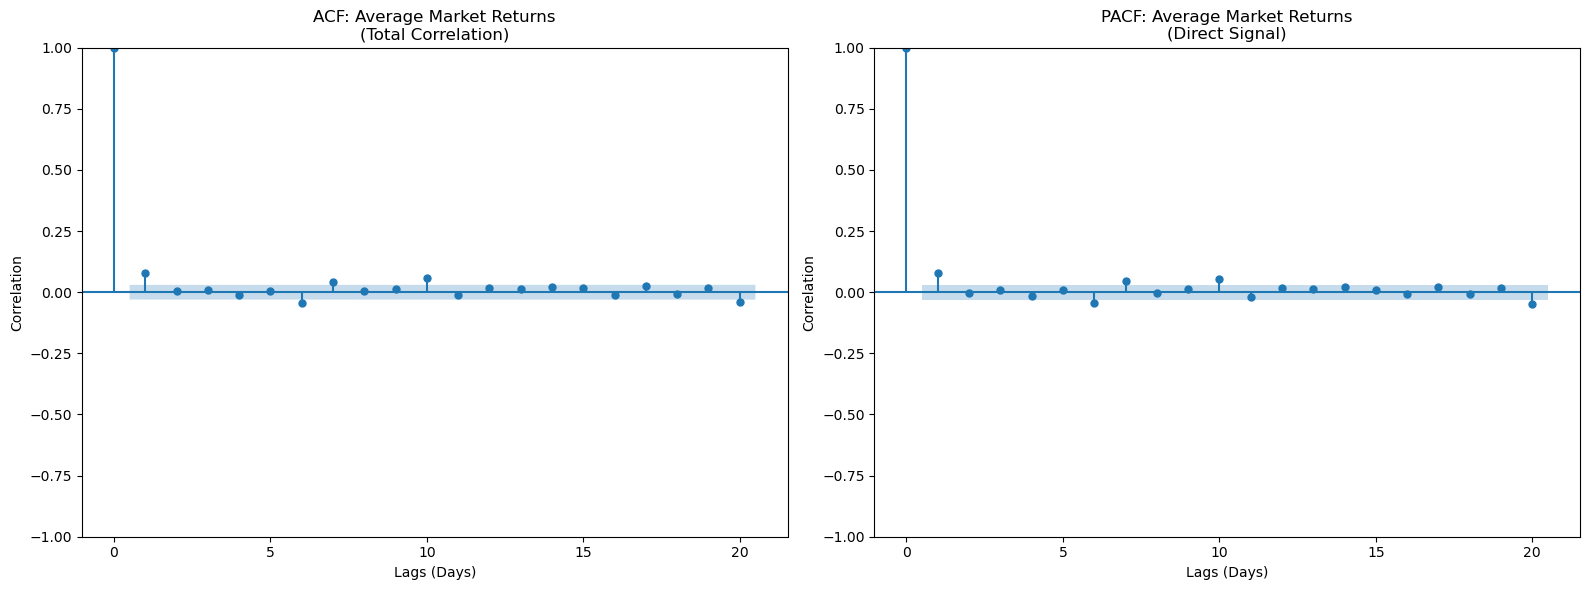

In [244]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# 1. Calculate the 'Market Factor' (Average return of all stocks)
# This washes out individual stock noise and shows the broad market pattern
avg_returns = returns_extended.mean(axis=1)

# 2. Create the plots
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# ACF (Autocorrelation Function)
# Shows the total correlation between today and a lag 'k' days ago
plot_acf(avg_returns.dropna(), lags=20, ax=ax[0], alpha=0.05)
ax[0].set_title("ACF: Average Market Returns\n(Total Correlation)")
ax[0].set_xlabel("Lags (Days)")
ax[0].set_ylabel("Correlation")

# PACF (Partial Autocorrelation Function)
# Shows ONLY the direct correlation of that specific lag, 
# stripping away the influence of the lags in between.
plot_pacf(avg_returns.dropna(), lags=20, ax=ax[1], alpha=0.05, method='ywm')
ax[1].set_title("PACF: Average Market Returns\n(Direct Signal)")
ax[1].set_xlabel("Lags (Days)")
ax[1].set_ylabel("Correlation")

plt.tight_layout()
plt.show()

### Rolling Averages of Market Returns

Figure below plots daily market returns along with 20-day and 100-day rolling averages. Both rolling averages remain close to zero for most of the sample period, despite large day-to-day fluctuations in returns. Short-horizon averages display brief deviations from zero, but these signals reverse frequently and do not persist. The long-horizon average is even more stable and shows no sustained trend.

This indicates that daily market returns exhibit weak and unstable trends, making short-horizon return prediction difficult. As a result, models trained on daily return data are primarily exposed to noise rather than persistent signal.


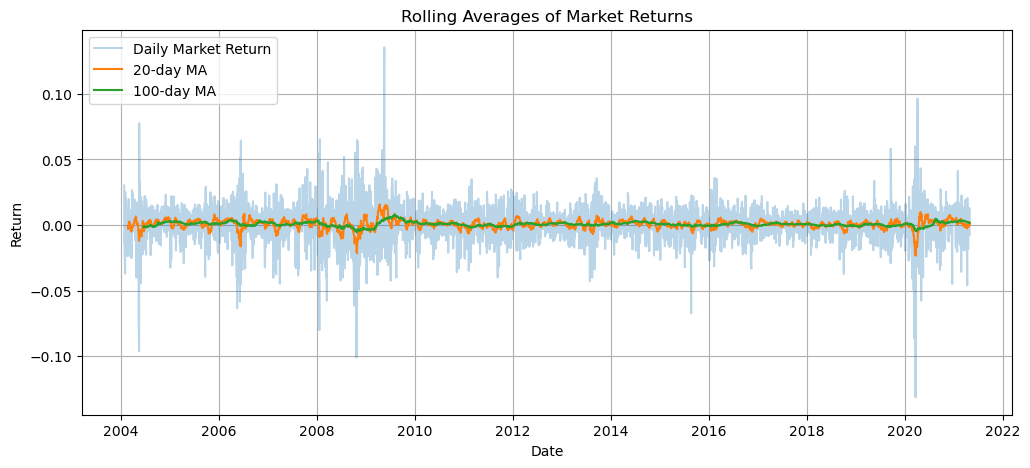

In [210]:
# --- ROLLING AVERAGES: MARKET RETURNS ---

market_returns = returns_extended.mean(axis=1)

short_window = 20   # ~1 month
long_window = 100   # ~5 months

roll_short = market_returns.rolling(short_window).mean()
roll_long = market_returns.rolling(long_window).mean()

plt.figure(figsize=(12, 5))
plt.plot(market_returns, alpha=0.3, label="Daily Market Return")
plt.plot(roll_short, label=f"{short_window}-day MA")
plt.plot(roll_long, label=f"{long_window}-day MA")
plt.title("Rolling Averages of Market Returns")
plt.xlabel("Date")
plt.ylabel("Return")
plt.legend()
plt.grid(True)
plt.show()


### Rolling Volatility and Risk Regimes

Figure below shows the 30-day rolling annualized volatility of market returns. Unlike rolling averages of returns, volatility exhibits clear persistence and clustering. Periods of elevated volatility tend to follow one another, while calm periods persist for extended durations.

Several distinct high-volatility regimes are visible, corresponding to market stress episodes, whereas prolonged low-volatility regimes characterize calmer market conditions. This indicates that while return levels are difficult to predict, risk dynamics display more stable and learnable structure.

These findings suggest that volatility—and broader risk regimes—are more predictable than returns themselves, which helps explain why models that attempt to forecast returns perform poorly, while risk-based or regime-aware approaches may be more effective.


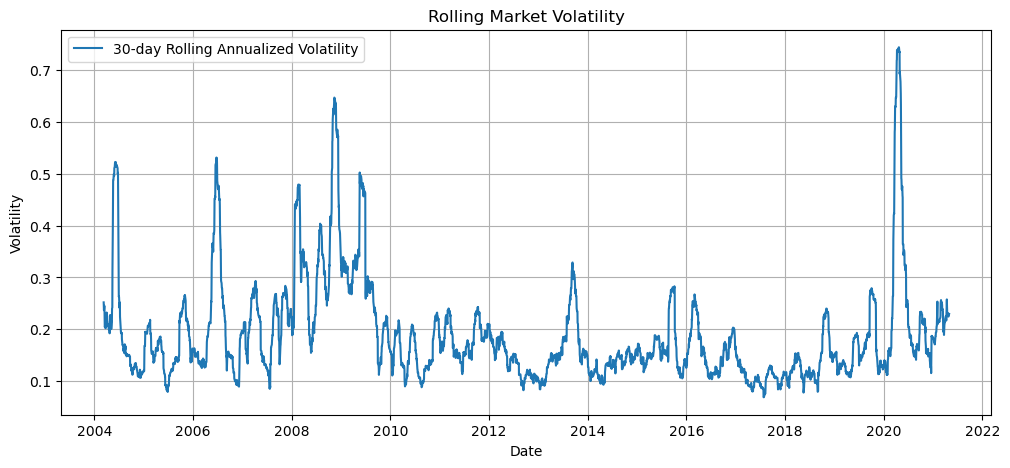

In [214]:
# Rolling volatility of market returns (extended universe)

market_returns = returns_extended.mean(axis=1)

vol_window = 30  # ~1.5 months
rolling_vol = market_returns.rolling(vol_window).std() * np.sqrt(252)

plt.figure(figsize=(12, 5))
plt.plot(rolling_vol, label="30-day Rolling Annualized Volatility")
plt.title("Rolling Market Volatility")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.legend()
plt.grid(True)
plt.show()


### Drawdowns and Recovery Dynamics

Figure below illustrates the market drawdown, defined as the percentage decline from the previous cumulative return peak. The plot shows that drawdowns are episodic but severe, with large losses occurring during well-known market stress periods, most notably around the global financial crisis in 2008 and the COVID-19 market shock in 2020.

These stress episodes are characterized by rapid drawdowns followed by prolonged recovery phases, indicating that losses accumulate quickly while recoveries occur more gradually. The timing of these drawdowns aligns closely with the elevated volatility regimes observed earlier, reinforcing the persistence of market stress once it emerges.

This behavior underscores the importance of diversification and robustness in portfolio construction. During extended drawdown periods such as 2008 and 2020, concentrated portfolios are particularly vulnerable, whereas broadly diversified portfolios are better positioned to withstand sustained market stress.


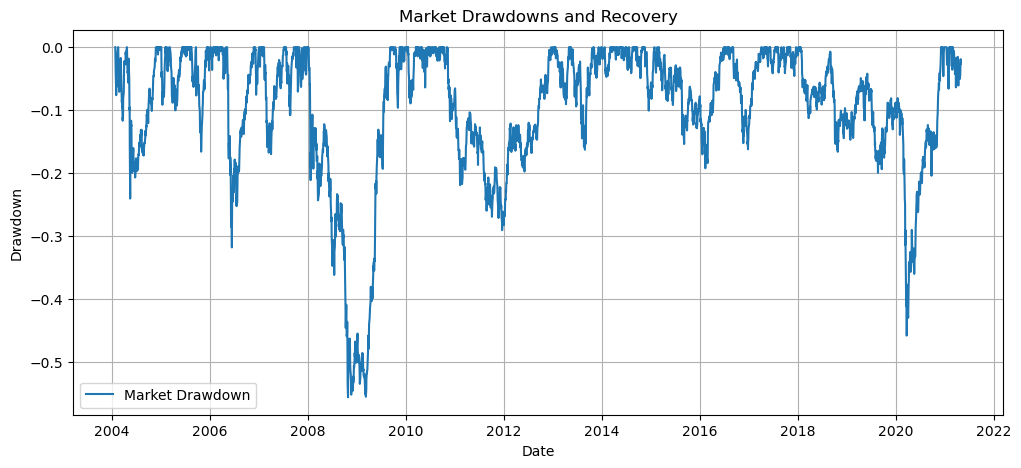

In [219]:
# --- DRAWDOWN ANALYSIS ---

# Market cumulative returns
market_returns = returns_extended.mean(axis=1)
cum_market = (1 + market_returns).cumprod()

# Running maximum
running_max = cum_market.cummax()

# Drawdown
drawdown = (cum_market - running_max) / running_max

plt.figure(figsize=(12, 5))
plt.plot(drawdown, label="Market Drawdown")
plt.title("Market Drawdowns and Recovery")
plt.xlabel("Date")
plt.ylabel("Drawdown")
plt.legend()
plt.grid(True)
plt.show()


### Regime Shifts: Calm vs Stressed Periods

Figure below explicitly identifies market regimes based on rolling volatility. Periods in which the 30-day rolling annualized volatility exceeds a threshold (75th percentile of historical volatility) are classified as **stressed regimes**, while periods below the threshold are classified as **calm regimes**.

The stressed regimes align closely with known market stress episodes, most notably during the global financial crisis around 2008–2009 and the COVID-19 shock in 2020. These periods are characterized by elevated and persistent volatility, whereas calm regimes exhibit lower and more stable volatility over extended durations.

This clear separation highlights the presence of regime shifts in market risk dynamics. While return levels show little persistent structure, volatility exhibits regime-dependent behavior that is both observable and persistent. This suggests that market risk is state-dependent, with stress regimes lasting long enough to materially affect portfolio performance and robustness.


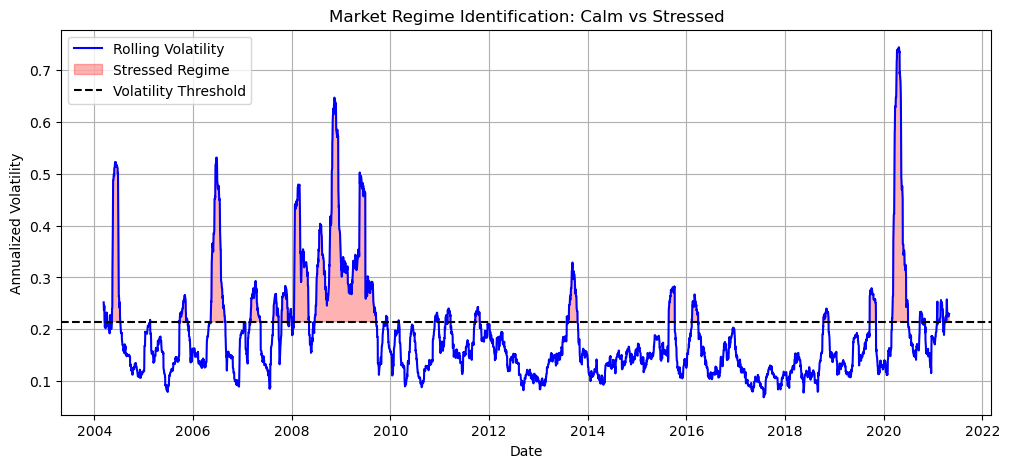

Volatility threshold used: 0.21458468855729043


In [223]:
# --- REGIME SHIFT IDENTIFICATION (CALM VS STRESSED) ---

market_returns = returns_extended.mean(axis=1)

# Rolling volatility (reuse)
vol_window = 30
rolling_vol = market_returns.rolling(vol_window).std() * np.sqrt(252)

# Define regime threshold (e.g. 75th percentile of volatility)
vol_threshold = rolling_vol.quantile(0.75)

# Regime labels
regime = pd.Series(
    np.where(rolling_vol > vol_threshold, "Stressed", "Calm"),
    index=rolling_vol.index
)

# Plot volatility with regimes highlighted
plt.figure(figsize=(12, 5))
plt.plot(rolling_vol, label="Rolling Volatility", color="blue")

plt.fill_between(
    rolling_vol.index,
    rolling_vol,
    vol_threshold,
    where=(rolling_vol > vol_threshold),
    color="red",
    alpha=0.3,
    label="Stressed Regime"
)

plt.axhline(vol_threshold, color="black", linestyle="--", label="Volatility Threshold")

plt.title("Market Regime Identification: Calm vs Stressed")
plt.xlabel("Date")
plt.ylabel("Annualized Volatility")
plt.legend()
plt.grid(True)
plt.show()

print("Volatility threshold used:", vol_threshold)


### Summary of Time-Series Pattern Discovery

Analysis of rolling averages, volatility, drawdowns, and regime shifts reveals a clear asymmetry in the structure of market returns. Rolling averages of daily returns remain close to zero across both short and long horizons, indicating that deviations in the conditional mean are weak, short-lived, and difficult to exploit. This suggests limited predictability of return levels at the daily frequency.

In contrast, rolling volatility exhibits strong persistence and clustering, with extended calm periods punctuated by distinct high-volatility regimes. Explicit regime classification based on volatility highlights clear stress periods, most notably during the global financial crisis of 2008–2009 and the COVID-19 shock in 2020. These stressed regimes persist over time and are associated with elevated risk.

Drawdown analysis further illustrates the economic consequences of these regimes. Market stress episodes are characterized by rapid and deep drawdowns followed by prolonged recovery periods, reinforcing the importance of robustness and diversification in portfolio construction. Together, these findings indicate that while return predictability is weak, risk dynamics exhibit meaningful and persistent structure.


----

### 4. Critical Reflection: Where ML Helps vs Hurts

This analysis examines the use of machine learning for estimating expected returns and incorporating those estimates into mean-variance portfolio optimization using daily equity return data.

### Where Machine Learning Helped

Machine learning was useful as a systematic diagnostic tool for assessing the predictability of daily returns. By modeling next-period returns using lagged returns and rolling features, ML enabled a structured test of whether historical price-based information contains exploitable signal. The resulting predictions provided insight into the sensitivity of portfolio construction to expected return estimates and highlighted how small differences in predicted returns can materially affect optimized portfolios.

### Where Machine Learning Hurt

Machine learning proved less effective when its return predictions were used directly as inputs to Markowitz optimization. At the daily horizon considered, return predictability was weak, and ML-based expected return estimates were noisy and unstable out of sample. When fed into the optimizer, these estimation errors were amplified, leading to highly concentrated portfolios and a sharp decline in diversification, as measured by the effective number of assets. This effect became more pronounced as the risk target increased and during stressed market regimes.

### Performance, Robustness, and Interpretation

Overall, ML-based portfolios did not improve performance relative to equal-weight or classic Markowitz benchmarks. Moreover, the use of ML return estimates reduced robustness by increasing sensitivity to estimation error and market stress, resulting in poor behavior during drawdowns. However, ML added interpretive value by clarifying the limits of return predictability at the daily frequency and by revealing how optimization frameworks can magnify noise in expected return inputs. These insights were reinforced by time-series pattern analysis showing weak structure in return means but strong structure in volatility and regimes.

### Future Scope

The results suggest that alternative uses of machine learning may be more effective. Future work could explore predicting longer-horizon returns, where noise is reduced and signals may be more persistent, or applying ML to quantities with stronger structure, such as volatility, drawdowns, or regime transitions. Additionally, ML outputs could be incorporated more conservatively into portfolio construction, for example through constraints or risk-aware adjustments, to mitigate the destabilizing effects observed when using ML estimates directly in mean-variance optimization.
